# Summarize Data

The `features` module packs a set of data summarization tools to calculate total counts, lengths, areas, and basic descriptive statistics of features and their attributes within areas or near other features. You can access these tools using the `summarize_data` sub module.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summarize-Data" data-toc-modified-id="Summarize-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summarize Data</a></span><ul class="toc-item"><li><span><a href="#Aggregate-points" data-toc-modified-id="Aggregate-points-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Aggregate points</a></span><ul class="toc-item"><li><span><a href="#Aggregate-earthquakes-by-state" data-toc-modified-id="Aggregate-earthquakes-by-state-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Aggregate earthquakes by state</a></span></li></ul></li></ul></li></ul></div>

## Aggregate points
In this example, let us observe how to use `aggregate_points` tool to summarize data from spot measurements by area. To learn more about this tool and the formula it uses, refer to the documentation [here](http://doc.arcgis.com/en/arcgis-online/use-maps/aggregate-points.htm)

In [29]:
# connect to GIS
from arcgis.gis import GIS
gis = GIS("portal url", "username", "password")

<Item title:"World Earthquake Locations" type:Feature Layer Collection owner:api_data_owner>
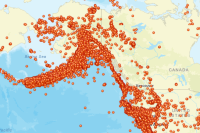

In [27]:
eq_search = gis.content.search(query="title:'World Earthquake Locations' owner:api_data_owner", item_type="Feature Layer Collection", max_items=1)
eq_item = eq_search[0]
eq_item

<Item title:"USA States (Generalized)" type:Feature Layer Collection owner:arcgis_python>
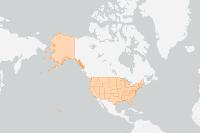

In [10]:
# search for USA states - area / polygon data
states_search = gis.content.search("title:'USA States (Generalized)'", 
                                   "feature layer", max_items=-1)
states_item = states_search[0]
states_item

Lets draw the layers on a map and observe how they are distributed

In [11]:
map1 = gis.map("USA")
map1

MapView(layout=Layout(height='400px', width='100%'))

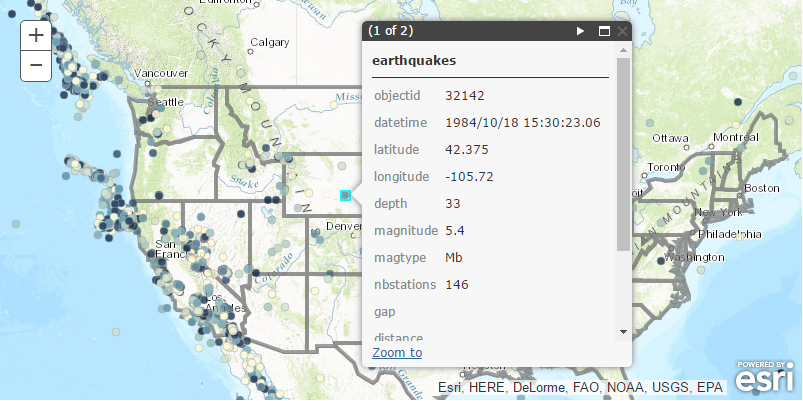</img>

In [12]:
map1.add_layer(states_item)

In [13]:
map1.add_layer(eq_item)

### Aggregate earthquakes by state
As you can see, a number of earthquakes fall on the boundary of tectonic plates ([ring of fire](https://en.wikipedia.org/wiki/Ring_of_Fire)). However, there are a few more dispersed into other states. It would be interesting to aggregate all the earthquakes by state and plot that as a chart. 

The `aggregate_points` tool in the `summarize_data` sub module is a valid candidate for such analyses. The example below shows how to run this tool using ArcGIS API for Python.

To start with, let us access the layers in the states and earthquakes items and view their attribute information to understand how the data can be summarized

In [14]:
eq_fl = eq_item.layers[0]
states_fl = states_item.layers[0]

We have accessed the layers in the items as `FeatureLayer` objects. We can query the `fields` property to understand what kind of attribute data is stored in the layers

In [15]:
#query the fields in eq_fl layer
for field in eq_fl.properties.fields:
    print(field['name'])

Event_Id
Community_Decimal_Intensity
Event_Detail
Distance_from_Epicenter__degree
Felt_Reports
Azimuthal_Gap__degrees_
Event_Magnitude
Magnitude_Type
Shake_Intensity
Source_Network
Seismic_Stations
Location_Name
Residual_Travel_Time__seconds_
Event_Significance
Network_Sources
Review_Status
Event_Time
Event_Title
Tsunami_Warning
Event_Type
Product_Types
Last_Updated
Event_Page
Latitude
Longitude
Elevation__meters_
Depth__kilometers_
OBJECTID
Event_Time_1
Event_Type_1
ObjectId2


In [16]:
# similarly for states data
for field in states_fl.properties.fields:
    print(field['name'], end="\t")

FID	STATE_NAME	STATE_FIPS	SUB_REGION	STATE_ABBR	POPULATION	POP_SQMI	POP2010	POP10_SQMI	WHITE	BLACK	AMERI_ES	ASIAN	HAWN_PI	HISPANIC	OTHER	MULT_RACE	MALES	FEMALES	AGE_UNDER5	AGE_5_9	AGE_10_14	AGE_15_19	AGE_20_24	AGE_25_34	AGE_35_44	AGE_45_54	AGE_55_64	AGE_65_74	AGE_75_84	AGE_85_UP	MED_AGE	MED_AGE_M	MED_AGE_F	HOUSEHOLDS	AVE_HH_SZ	HSEHLD_1_M	HSEHLD_1_F	MARHH_CHD	MARHH_NO_C	MHH_CHILD	FHH_CHILD	FAMILIES	AVE_FAM_SZ	HSE_UNITS	VACANT	OWNER_OCC	RENTER_OCC	NO_FARMS12	AVE_SIZE12	CROP_ACR12	AVE_SALE12	SQMI	Shape__Area	Shape__Length	GlobalID	Shape__Area_2	Shape__Length_2	

Let us aggreate the points by state and summarize the `magnitude` field and use `mean` as the summary type.

In [17]:
# this cell will take a few minutes to execute because of several data points
from arcgis.features import summarize_data
sum_fields = ['Event_Magnitude Mean', 'Depth__kilometers_ Min']
eq_summary = summarize_data.aggregate_points(point_layer = eq_fl,
                                            polygon_layer = states_fl,
                                            keep_boundaries_with_no_points=False,
                                            summary_fields=sum_fields)

{"cost": 478.947}


When running the tool above, we did not specify a name for the `output_name` parameter. Hence the analyses results were not stored on the portal, instead stored in the variable `eq_summary`.

In [18]:
eq_summary

{'aggregated_layer': <FeatureCollection>, 'group_summary': ''}

In [19]:
# access the aggregation feature colleciton
eq_aggregate_fc = eq_summary['aggregated_layer']

#query this feature collection to get a data as a feature set
eq_aggregate_fset = eq_aggregate_fc.query()

`FeatureSet` objects support visualizing attribute information as a pandas dataframe. This is a neat feature since you do not have to iterate through each feature to view their attribute information.

Let us view the summary results as a pandas dataframe table. Note, the `aggregate_points` tool appends the polygon layer's original set of fields to the analysis result in order to provide it context

In [20]:
aggregation_df = eq_aggregate_fset.sdf
aggregation_df.head()

,OBJECTID,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,...,GlobalID,Shape__Area_2,Shape__Length_2,Shape_Length,Shape_Area,mean_Event_Magnitude,min_Depth__kilometers_,Point_Count,AnalysisArea,SHAPE
0,1,Wyoming,56,Mountain,WY,598332,6.1,563626,5.8,511279,...,{9DC7C7AC-FE50-46FF-A98A-BC9B99E0CED0},474117105945.773438,2775149.430913,2775149.430947,474117105972.575684,4.550545,-1.4,110,97797.234015,"{""rings"": [[[-11583195.4614, 5115880.653200000..."
1,3,Alaska,02,Pacific,AK,744733,1.3,710231,1.2,473576,...,{FC1D546E-050D-40E0-8674-D380F839AD76},8101401247192.390625,59249543.508505,59249543.507812,8101401247161.800781,4.474101,-3.0,2802,576545.958618,"{""rings"": [[[-17959594.8053, 8122953.575199999..."
2,5,North Dakota,38,West North Central,ND,793399,11.2,672591,9.5,605449,...,{4C973C13-C535-45DD-B5CB-0BD837DAE90D},400989888326.039062,2688189.824234,2688189.824286,400989888305.082947,5.5,0.0,1,70812.483321,"{""rings"": [[[-10990621.962, 5770462.616400003]..."
3,6,South Dakota,46,West North Central,SD,880051,11.4,814180,10.6,699392,...,{2064228A-2CC4-4E74-B492-34EF98939518},392302335744.371094,2824245.235541,2824245.23589,392302335746.93811,4.3,0.0,8,77186.489617,"{""rings"": [[[-11442350.6328, 5311257.036700003..."
4,7,Delaware,10,South Atlantic,DE,971403,491.7,897934,454.5,618617,...,{C83CE019-1814-4B07-8111-6B414909808F},8823228994.324219,535395.672895,535395.672768,8823228992.748075,4.1,9.87,1,2054.707985,"{""rings"": [[[-8427672.8732, 4658497.009999998]..."


Thus, from our data, of the 50 states, only 23 have had earthquakes. Let us plot a bar chart to view which states had the most earthquakes

<AxesSubplot: xlabel='STATE_NAME'>

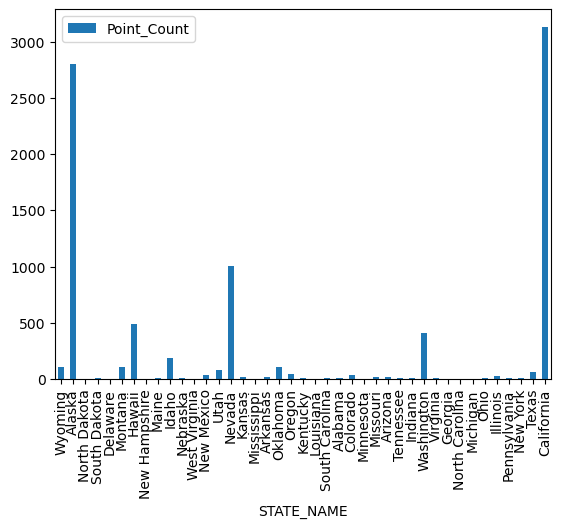

In [21]:
%matplotlib inline
aggregation_df.plot('STATE_NAME','Point_Count', kind='bar')

Clearly, California tops the list with the most number of earthquakes. Let us view what the average intensity and minimum depth is in the plots below:

array([<AxesSubplot: title={'center': 'min_Depth__kilometers_'}, xlabel='STATE_NAME'>,
       <AxesSubplot: title={'center': 'mean_Event_Magnitude'}, xlabel='STATE_NAME'>],
      dtype=object)

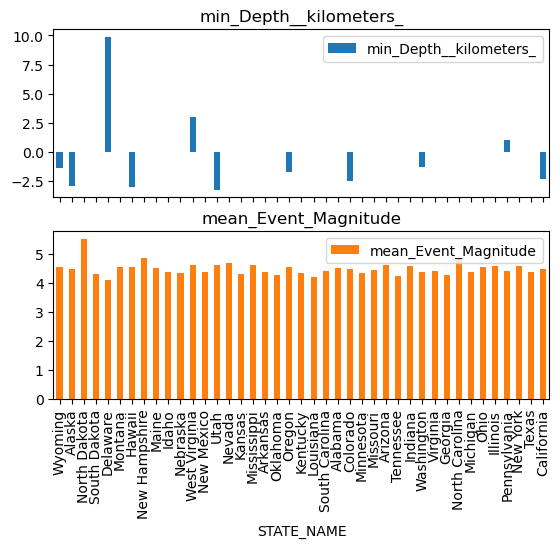

In [23]:
aggregation_df.plot('STATE_NAME',['min_Depth__kilometers_', 'mean_Event_Magnitude'],kind='bar', subplots=True)